# Introduction
This notebook runs TFT tensorflow2 version on the covid dataset. You can recreate the merged input file using the `Data preparation` notebook. For a fresh model training, remove any files from the `checkpoint` folder.


# Initial Setup
## Importing libraries

In [1]:
import tensorflow as tf
import os, gc, json
import pandas as pd
from pandas import to_datetime

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 1.5)

2022-06-21 13:46:48.295104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import sys
sys.path.append( '../../../v0/' )
from script.utils import train_validation_test_split, scale_back, calculate_result, sumCases
from Class.Trainer import Trainer
from Class.ParameterManager import ParameterManager
from Class.DataProcessor import DataProcessor
from Class.Plotter import PlotResults, PlotWeights

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-21 13:46:54.033956: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 13:46:54.035404: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-21 13:46:54.079814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-21 13:46:54.079849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-21 13:46:54.084492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-21 13:46:54.084548: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [4]:
import torch
gc.collect()
torch.cuda.empty_cache()

## Adding google drive
Set `running_on_colab= True` if running on Google colab.

In [5]:
running_on_colab = False

if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/My Drive/Projects/Covid/TF2

## Setting up folders
The current folder has the following structure

* Rurality_cut.csv
* config.json
* output
  * checkpoints
  * figures

In [6]:
from dataclasses import dataclass

@dataclass
class args:
    # folder where the cleaned feature file are at
    dataPath = 'Rurality_cut.csv'

    outputPath = 'output/'
    configPath = 'config.json'
    checkpoint = os.path.join(outputPath, 'checkpoints')
    restore = False

In [7]:
# output paths
checkpoint_folder = args.checkpoint
figure_folder = os.path.join(args.outputPath, "figures")

# this eventually creates output folder if it doesn't exist
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder, exist_ok=True)

if not os.path.exists(figure_folder):
    os.makedirs(figure_folder, exist_ok=True)

In [8]:
print(f'Loading config.json from {args.configPath}')
with open(args.configPath) as inputfile:
    config = json.load(inputfile)
    inputfile.close()

Loading config.json from config.json


## Load data

In [9]:
print(f'Loading input data from {args.dataPath}')
df = pd.read_csv(args.dataPath)
print(f'Input feature file shape {df.shape}')

Loading input data from Rurality_cut.csv
Input feature file shape (52650, 25)


In [10]:
df['Date'] = to_datetime(df['Date']) 
df['FIPS'] = df['FIPS'].astype(str)

# Pre-processing

## Parameter manager

In [11]:
parameterManager = ParameterManager(config)
print(f'Column mappings: {parameterManager.col_mappings}\n')

Column mappings: {'Static': ['AgeDist', 'AirPollution', 'HealthDisp'], 'ID': ['FIPS'], 'Time': ['TimeFromStart'], 'Target': ['Cases'], 'Future': ['LinearSpace', 'Constant', 'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'], 'Known Regular': ['AgeDist', 'AirPollution', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']}



## Train validation test split and Scaling

In [12]:
train_data, validation_data, test_data, target_scaler = train_validation_test_split(df, parameterManager, scale=True)
print(f'Number train data is {train_data.shape[0]}, validation {validation_data.shape[0]}, test {test_data.shape[0]}')

Number train data is 41210, validation 5720, test 5720


## Create batches

In [13]:
dataProcessor = DataProcessor(
    parameterManager.total_sequence_length, parameterManager.col_mappings, parameterManager.data_params
)

train_batch = dataProcessor.prepare_batch(train_data, train=True)
validation_batch = dataProcessor.prepare_batch(validation_data)

gc.collect()

2022-06-21 13:46:56.370040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 13:46:56.370219: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 13:46:56.372340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-21 13:46:56.372383: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-21 13:46:56.372427: I tensorflow/stream_executor/platfor

0

# Training

## Util

In [14]:
def plot_history(history:dict,  figure_path:str=None, show=False):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True)
    x = range(1, len(history['train_loss'])+1)

    # label_text   = [f'{int(loc/1000)}k' for loc in plt.yticks()[0]]
    # ax.set_yticklabels(label_text)

    ax[0].set_title('Training history')
    ax[0].plot(x, history['train_loss'], color='blue', label='Train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Squared Error of daily covid cases')
    ax[0].legend()

    ax[1].set_title('Validation history')
    ax[1].plot(x, history['validation_loss'], color='green', label='Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error of daily covid cases')
    ax[1].legend()

    fig.tight_layout()
    if figure_path:
        plt.savefig(figure_path)
    if show:
        plt.show()

## Create Trainer

In [15]:
trainer = Trainer(parameterManager, disable_progress=False)
model = trainer.create_model()

## Optimizer and Checkpoint

In [16]:
optimizer_params = parameterManager.optimizer_params
optimizer = tf.keras.optimizers.Adam(
    learning_rate=optimizer_params['learning_rate'], clipnorm=optimizer_params['clipnorm']
)

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpointManager = tf.train.CheckpointManager(checkpoint, checkpoint_folder, max_to_keep=1)

In [17]:
if args.restore and checkpointManager.latest_checkpoint:
    model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
    if model is None:
        sys.exit(-1)

## Training loop

Running the model for 60 epochs.
Epoch 1


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2022-06-21 13:47:12.679776: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-21 13:47:12.816400: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-06-21 13:47:17.321913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-21 13:47:17.553620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0139545, time 0:01:12.171571. Validation loss 0.0206417, time 0:00:06.463405
Loss improved from inf to 0.0139545

Saving checkpoint for epoch 1 at output/checkpoints/ckpt-1
Epoch 2


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00497149, time 0:00:39.827460. Validation loss 0.0210961, time 0:00:00.739168
Loss improved from 0.0139545 to 0.00497149

Saving checkpoint for epoch 2 at output/checkpoints/ckpt-2
Epoch 3


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00479124, time 0:00:40.108282. Validation loss 0.0196316, time 0:00:00.671035
Loss improved from 0.00497149 to 0.00479124

Saving checkpoint for epoch 3 at output/checkpoints/ckpt-3
Epoch 4


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00461526, time 0:00:39.578485. Validation loss 0.0203545, time 0:00:00.705630
Loss improved from 0.00479124 to 0.00461526

Saving checkpoint for epoch 4 at output/checkpoints/ckpt-4
Epoch 5


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00450855, time 0:00:40.178807. Validation loss 0.0207302, time 0:00:00.713746
Loss improved from 0.00461526 to 0.00450855

Saving checkpoint for epoch 5 at output/checkpoints/ckpt-5
Epoch 6


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00438597, time 0:00:39.579351. Validation loss 0.0198135, time 0:00:00.686068
Loss improved from 0.00450855 to 0.00438597

Saving checkpoint for epoch 6 at output/checkpoints/ckpt-6
Epoch 7


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00434502, time 0:00:40.073455. Validation loss 0.0205336, time 0:00:00.715492
Loss improved from 0.00438597 to 0.00434502

Saving checkpoint for epoch 7 at output/checkpoints/ckpt-7
Epoch 8


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00431082, time 0:00:40.096427. Validation loss 0.0203826, time 0:00:00.650601
Loss improved from 0.00434502 to 0.00431082

Saving checkpoint for epoch 8 at output/checkpoints/ckpt-8
Epoch 9


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00432453, time 0:00:40.036979. Validation loss 0.0185203, time 0:00:00.687022
Early stop counter 1/60
Epoch 10


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0042681, time 0:00:40.401156. Validation loss 0.020162, time 0:00:00.663506
Loss improved from 0.00431082 to 0.0042681

Saving checkpoint for epoch 10 at output/checkpoints/ckpt-9
Epoch 11


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00422674, time 0:00:40.164523. Validation loss 0.0195067, time 0:00:00.713084
Loss improved from 0.0042681 to 0.00422674

Saving checkpoint for epoch 11 at output/checkpoints/ckpt-10
Epoch 12


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00411191, time 0:00:40.141723. Validation loss 0.0208505, time 0:00:00.661633
Loss improved from 0.00422674 to 0.00411191

Saving checkpoint for epoch 12 at output/checkpoints/ckpt-11
Epoch 13


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00413632, time 0:00:39.813859. Validation loss 0.0194045, time 0:00:00.697903
Early stop counter 1/60
Epoch 14


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00398867, time 0:00:39.959233. Validation loss 0.0200613, time 0:00:00.693408
Loss improved from 0.00411191 to 0.00398867

Saving checkpoint for epoch 14 at output/checkpoints/ckpt-12
Epoch 15


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00402907, time 0:00:40.281733. Validation loss 0.0197945, time 0:00:00.712772
Early stop counter 1/60
Epoch 16


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00393666, time 0:00:40.068010. Validation loss 0.0217978, time 0:00:00.664317
Loss improved from 0.00398867 to 0.00393666

Saving checkpoint for epoch 16 at output/checkpoints/ckpt-13
Epoch 17


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00387507, time 0:00:39.986440. Validation loss 0.0191281, time 0:00:00.695416
Loss improved from 0.00393666 to 0.00387507

Saving checkpoint for epoch 17 at output/checkpoints/ckpt-14
Epoch 18


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00385136, time 0:00:40.292060. Validation loss 0.0199163, time 0:00:00.657690
Loss improved from 0.00387507 to 0.00385136

Saving checkpoint for epoch 18 at output/checkpoints/ckpt-15
Epoch 19


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00380817, time 0:00:40.047730. Validation loss 0.0212624, time 0:00:00.669298
Loss improved from 0.00385136 to 0.00380817

Saving checkpoint for epoch 19 at output/checkpoints/ckpt-16
Epoch 20


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0038087, time 0:00:40.126292. Validation loss 0.0196803, time 0:00:00.648908
Early stop counter 1/60
Epoch 21


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00377739, time 0:00:40.043469. Validation loss 0.0204074, time 0:00:00.680368
Loss improved from 0.00380817 to 0.00377739

Saving checkpoint for epoch 21 at output/checkpoints/ckpt-17
Epoch 22


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00376393, time 0:00:40.078027. Validation loss 0.0191838, time 0:00:00.683351
Loss improved from 0.00377739 to 0.00376393

Saving checkpoint for epoch 22 at output/checkpoints/ckpt-18
Epoch 23


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00370984, time 0:00:40.229716. Validation loss 0.0228437, time 0:00:00.729664
Loss improved from 0.00376393 to 0.00370984

Saving checkpoint for epoch 23 at output/checkpoints/ckpt-19
Epoch 24


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00377198, time 0:00:40.202048. Validation loss 0.0200594, time 0:00:00.679720
Early stop counter 1/60
Epoch 25


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00365575, time 0:00:40.345562. Validation loss 0.022279, time 0:00:00.720664
Loss improved from 0.00370984 to 0.00365575

Saving checkpoint for epoch 25 at output/checkpoints/ckpt-20
Epoch 26


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00364118, time 0:00:40.190455. Validation loss 0.0203674, time 0:00:00.677502
Loss improved from 0.00365575 to 0.00364118

Saving checkpoint for epoch 26 at output/checkpoints/ckpt-21
Epoch 27


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00367112, time 0:00:40.171848. Validation loss 0.0195739, time 0:00:00.640499
Early stop counter 1/60
Epoch 28


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00361842, time 0:00:40.103928. Validation loss 0.0203532, time 0:00:00.669612
Loss improved from 0.00364118 to 0.00361842

Saving checkpoint for epoch 28 at output/checkpoints/ckpt-22
Epoch 29


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00357123, time 0:00:40.241094. Validation loss 0.0199235, time 0:00:00.711538
Loss improved from 0.00361842 to 0.00357123

Saving checkpoint for epoch 29 at output/checkpoints/ckpt-23
Epoch 30


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00363541, time 0:00:40.115277. Validation loss 0.0189636, time 0:00:00.709621
Early stop counter 1/60
Epoch 31


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00361874, time 0:00:40.184462. Validation loss 0.0190699, time 0:00:00.688334
Early stop counter 2/60
Epoch 32


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00357822, time 0:00:40.273604. Validation loss 0.019979, time 0:00:00.675548
Early stop counter 3/60
Epoch 33


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00353331, time 0:00:40.245396. Validation loss 0.0189472, time 0:00:00.703667
Loss improved from 0.00357123 to 0.00353331

Saving checkpoint for epoch 33 at output/checkpoints/ckpt-24
Epoch 34


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00353544, time 0:00:40.251670. Validation loss 0.0201973, time 0:00:00.683432
Early stop counter 1/60
Epoch 35


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00350779, time 0:00:39.982409. Validation loss 0.0191287, time 0:00:00.674643
Loss improved from 0.00353331 to 0.00350779

Saving checkpoint for epoch 35 at output/checkpoints/ckpt-25
Epoch 36


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00353075, time 0:00:40.190470. Validation loss 0.019024, time 0:00:00.684668
Early stop counter 1/60
Epoch 37


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0034963, time 0:00:40.059537. Validation loss 0.0194785, time 0:00:00.724689
Loss improved from 0.00350779 to 0.0034963

Saving checkpoint for epoch 37 at output/checkpoints/ckpt-26
Epoch 38


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00349745, time 0:00:40.200482. Validation loss 0.0196553, time 0:00:00.695155
Early stop counter 1/60
Epoch 39


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00343469, time 0:00:40.232766. Validation loss 0.019313, time 0:00:00.659160
Loss improved from 0.0034963 to 0.00343469

Saving checkpoint for epoch 39 at output/checkpoints/ckpt-27
Epoch 40


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00340943, time 0:00:40.321278. Validation loss 0.0221534, time 0:00:00.720710
Loss improved from 0.00343469 to 0.00340943

Saving checkpoint for epoch 40 at output/checkpoints/ckpt-28
Epoch 41


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00339243, time 0:00:40.192874. Validation loss 0.018761, time 0:00:00.699312
Loss improved from 0.00340943 to 0.00339243

Saving checkpoint for epoch 41 at output/checkpoints/ckpt-29
Epoch 42


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.003359, time 0:00:40.138923. Validation loss 0.0191291, time 0:00:00.699646
Loss improved from 0.00339243 to 0.003359

Saving checkpoint for epoch 42 at output/checkpoints/ckpt-30
Epoch 43


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00331355, time 0:00:40.135720. Validation loss 0.0197916, time 0:00:00.722029
Loss improved from 0.003359 to 0.00331355

Saving checkpoint for epoch 43 at output/checkpoints/ckpt-31
Epoch 44


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00330871, time 0:00:40.151871. Validation loss 0.0198989, time 0:00:00.693567
Loss improved from 0.00331355 to 0.00330871

Saving checkpoint for epoch 44 at output/checkpoints/ckpt-32
Epoch 45


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00330605, time 0:00:40.081400. Validation loss 0.020254, time 0:00:00.683571
Loss improved from 0.00330871 to 0.00330605

Saving checkpoint for epoch 45 at output/checkpoints/ckpt-33
Epoch 46


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.003253, time 0:00:40.174496. Validation loss 0.0202088, time 0:00:00.640690
Loss improved from 0.00330605 to 0.003253

Saving checkpoint for epoch 46 at output/checkpoints/ckpt-34
Epoch 47


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00326627, time 0:00:40.375727. Validation loss 0.0203898, time 0:00:00.720620
Early stop counter 1/60
Epoch 48


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00325955, time 0:00:40.387101. Validation loss 0.0200858, time 0:00:00.712836
Early stop counter 2/60
Epoch 49


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00325169, time 0:00:40.301531. Validation loss 0.0196382, time 0:00:00.650107
Loss improved from 0.003253 to 0.00325169

Saving checkpoint for epoch 49 at output/checkpoints/ckpt-35
Epoch 50


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0032124, time 0:00:40.274817. Validation loss 0.0203075, time 0:00:00.695037
Loss improved from 0.00325169 to 0.0032124

Saving checkpoint for epoch 50 at output/checkpoints/ckpt-36
Epoch 51


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00317831, time 0:00:40.654523. Validation loss 0.0194832, time 0:00:00.628978
Loss improved from 0.0032124 to 0.00317831

Saving checkpoint for epoch 51 at output/checkpoints/ckpt-37
Epoch 52


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0031926, time 0:00:40.328256. Validation loss 0.0192944, time 0:00:00.652737
Early stop counter 1/60
Epoch 53


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00314663, time 0:00:40.269888. Validation loss 0.0198097, time 0:00:00.714004
Loss improved from 0.00317831 to 0.00314663

Saving checkpoint for epoch 53 at output/checkpoints/ckpt-38
Epoch 54


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00311265, time 0:00:40.369353. Validation loss 0.0203459, time 0:00:00.710969
Loss improved from 0.00314663 to 0.00311265

Saving checkpoint for epoch 54 at output/checkpoints/ckpt-39
Epoch 55


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0030981, time 0:00:40.442589. Validation loss 0.0199467, time 0:00:00.709123
Loss improved from 0.00311265 to 0.0030981

Saving checkpoint for epoch 55 at output/checkpoints/ckpt-40
Epoch 56


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00305579, time 0:00:40.340696. Validation loss 0.0196475, time 0:00:00.711858
Loss improved from 0.0030981 to 0.00305579

Saving checkpoint for epoch 56 at output/checkpoints/ckpt-41
Epoch 57


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.0030234, time 0:00:40.234544. Validation loss 0.0192746, time 0:00:00.665496
Loss improved from 0.00305579 to 0.0030234

Saving checkpoint for epoch 57 at output/checkpoints/ckpt-42
Epoch 58


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00302187, time 0:00:40.417676. Validation loss 0.0207966, time 0:00:00.635830
Loss improved from 0.0030234 to 0.00302187

Saving checkpoint for epoch 58 at output/checkpoints/ckpt-43
Epoch 59


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00301135, time 0:00:40.441565. Validation loss 0.0198688, time 0:00:00.679612
Loss improved from 0.00302187 to 0.00301135

Saving checkpoint for epoch 59 at output/checkpoints/ckpt-44
Epoch 60


Train:   0%|          | 0/617 [00:00<?, ?it/s]

Validation:   0%|          | 0/62 [00:00<?, ?it/s]

Train loss 0.00298042, time 0:00:40.154445. Validation loss 0.0196059, time 0:00:00.683868
Loss improved from 0.00301135 to 0.00298042

Saving checkpoint for epoch 60 at output/checkpoints/ckpt-45


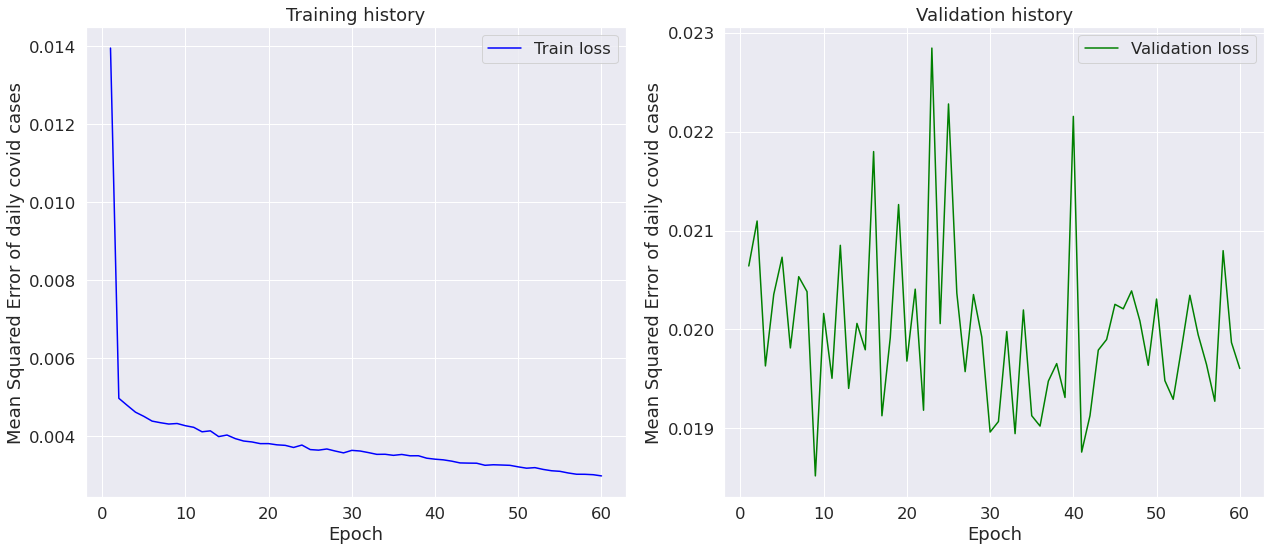

6169

In [18]:
history = trainer.fit(
    model, optimizer, train_batch, validation_batch, checkpointManager, early_stopping_patience=parameterManager.early_stopping_patience
)

plot_history(history, os.path.join(figure_folder, 'history.png'), show=True)
gc.collect()

## Testing

In [19]:
# load the best checkpoint by validation loss
model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
if model is None:
    sys.exit(-1)

Checkpoint restored from output/checkpoints/ckpt-45


### Train predictions

In [20]:
train_batch = dataProcessor.prepare_batch(train_data)
train_preds, train_actuals, train_attn_weights = trainer.predict(model, train_batch)

train_actuals = scale_back(train_actuals, target_scaler, parameterManager.target_sequence_length)
train_preds = scale_back(train_preds, target_scaler, parameterManager.target_sequence_length)

train_mae, train_rmse, train_smape = calculate_result(train_actuals, train_preds)
print(f'Train MAE {train_mae}, RMSE {train_rmse}, SMAPE {train_smape}')
gc.collect()

  0%|          | 0/617 [00:00<?, ?it/s]

Train MAE 4.7416, RMSE 11.3057, SMAPE 1.0752


20

### Validation predictions

In [21]:
validation_preds, validation_actuals, _ = trainer.predict(model, validation_batch)

validation_preds = scale_back(validation_preds, target_scaler, parameterManager.target_sequence_length)
validation_actuals = scale_back(validation_actuals,  target_scaler, parameterManager.target_sequence_length)

validation_mae, validation_rmse, validation_smape = calculate_result(validation_actuals, validation_preds)
print(f'Validation MAE {validation_mae}, RMSE {validation_rmse}, SMAPE {validation_smape}')

  0%|          | 0/62 [00:00<?, ?it/s]

Validation MAE 21.773, RMSE 49.5432, SMAPE 1.2552


### Test

In [22]:
test_batch = dataProcessor.prepare_batch(test_data)
test_preds, test_actuals, _ = trainer.predict(model, test_batch)

test_actuals = scale_back(test_actuals, target_scaler, parameterManager.target_sequence_length) 
test_preds = scale_back(test_preds, target_scaler, parameterManager.target_sequence_length)

test_mae, test_rmse, test_smape = calculate_result(test_actuals, test_preds)
print(f'Test MAE {test_mae}, RMSE {test_rmse}, SMAPE {test_smape}')

  0%|          | 0/62 [00:00<?, ?it/s]

Test MAE 5.4197, RMSE 13.0432, SMAPE 1.5602


### Delete model

In [23]:
del model
gc.collect()

99

# Result plot

In [24]:
number_of_locations = df[parameterManager.col_mappings['ID']].nunique().values[0]
print(f'Number of locations {number_of_locations}')
locs = df[parameterManager.col_mappings['ID']].iloc[:number_of_locations, 0].values

Number of locations 65


## Train

Saving output/figures/Summed plot - train.png


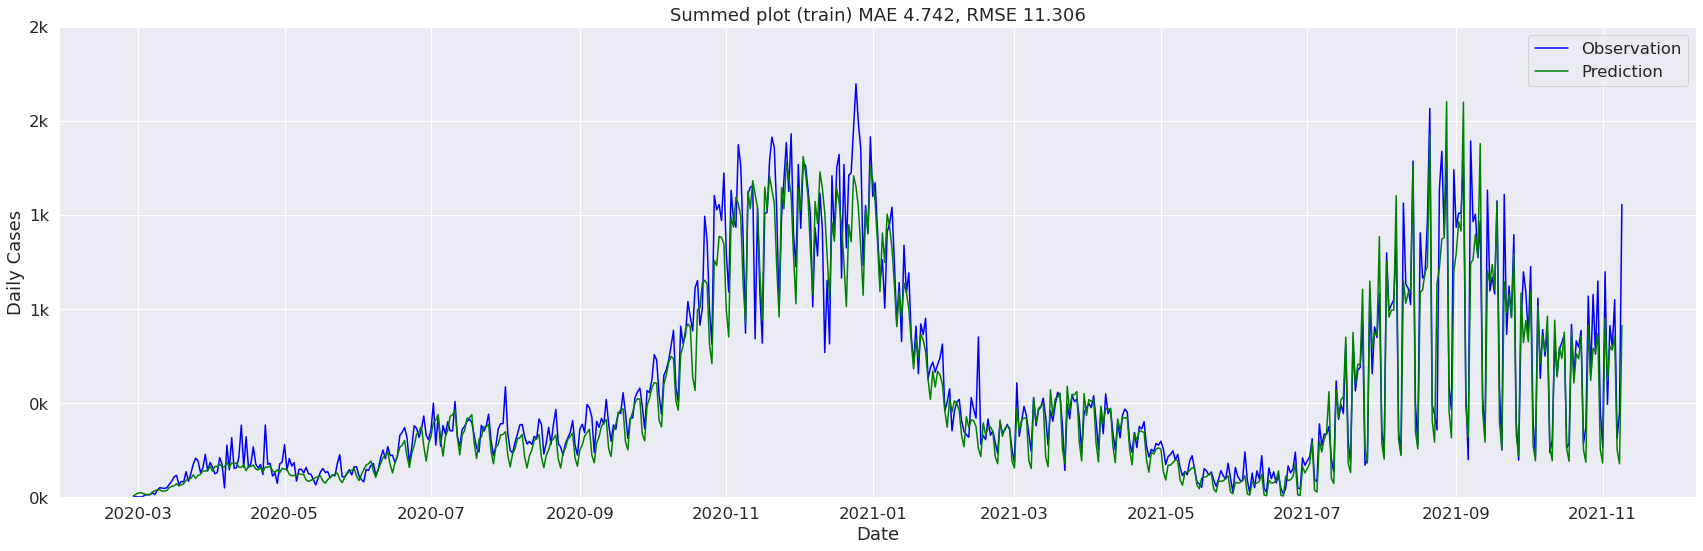

In [25]:
targets, predictions = sumCases(train_actuals, train_preds, number_of_locations)

resultPlotter = PlotResults(targets, predictions, parameterManager.train_start, locs, figure_folder)
plot_title = f'Summed plot (train) MAE {train_mae:0.3f}, RMSE {train_rmse:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - train', figsize=(24, 8))

## Validation

Saving output/figures/Summed plot - validation.png


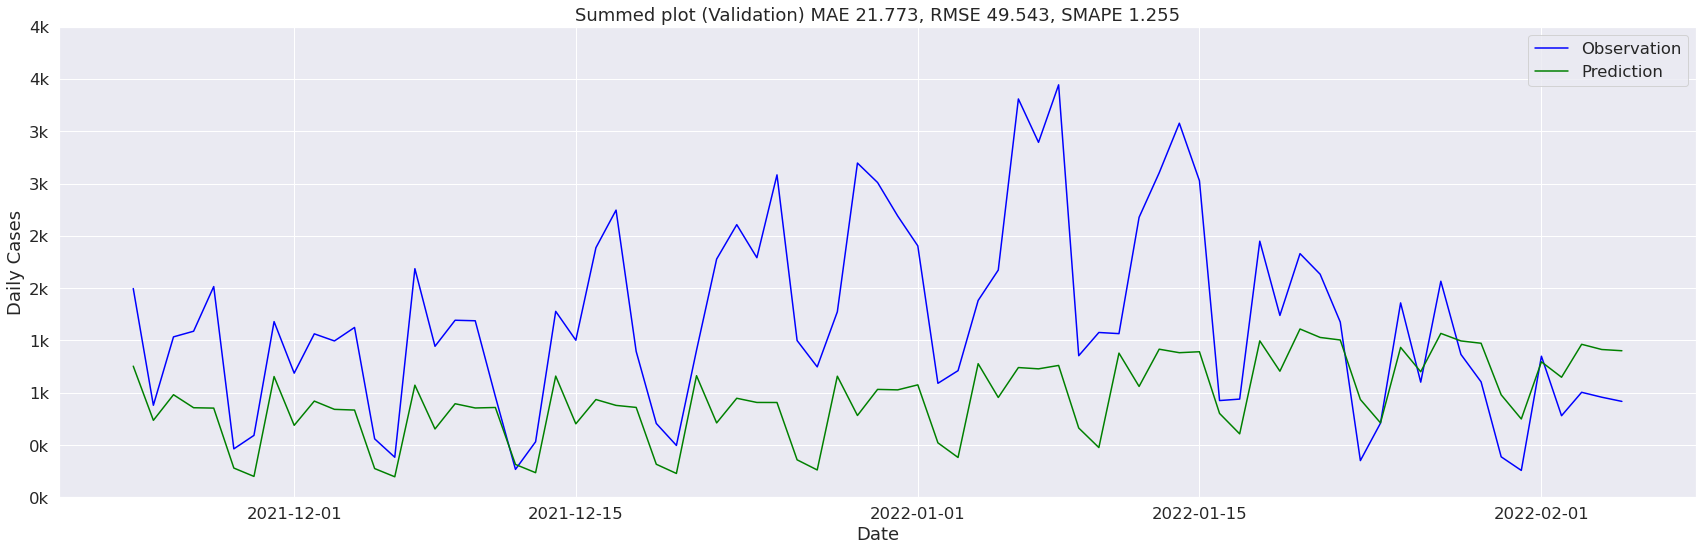

In [26]:
targets, predictions = sumCases(validation_actuals, validation_preds, number_of_locations)
resultPlotter = PlotResults(targets, predictions, parameterManager.validation_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - validation')

## Test

Saving output/figures/Summed plot - test.png


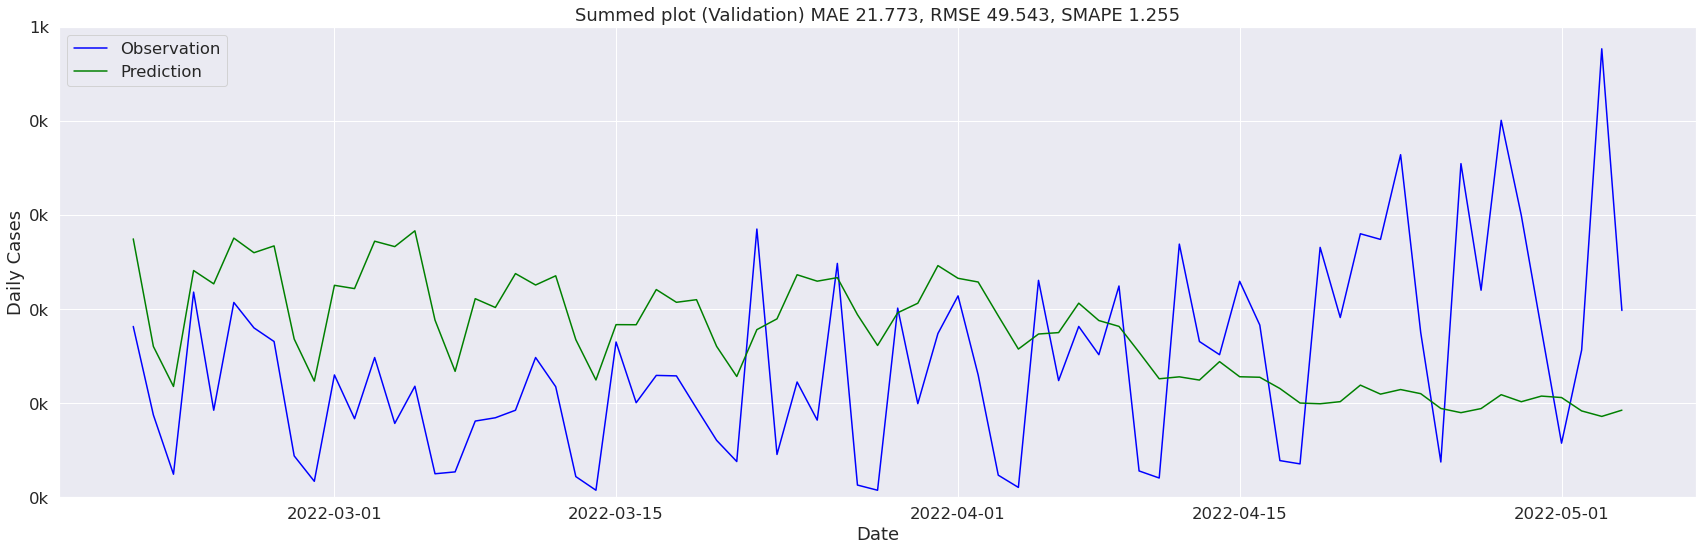

In [27]:
targets, predictions = sumCases(test_actuals, test_preds, number_of_locations)
PlotC = PlotResults(targets, predictions, parameterManager.test_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

PlotC.makeSummedPlot(plot_title, figure_name='Summed plot - test')

# Interpret

Saving output/figures/Static input selection weights by variable.png


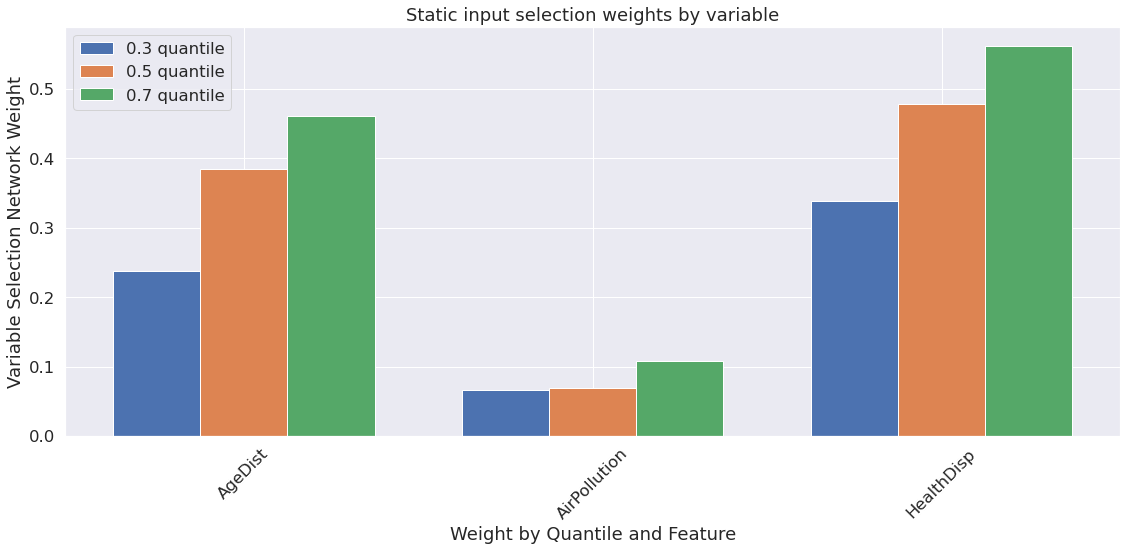

Saving output/figures/Future known input selection weights by variable.png


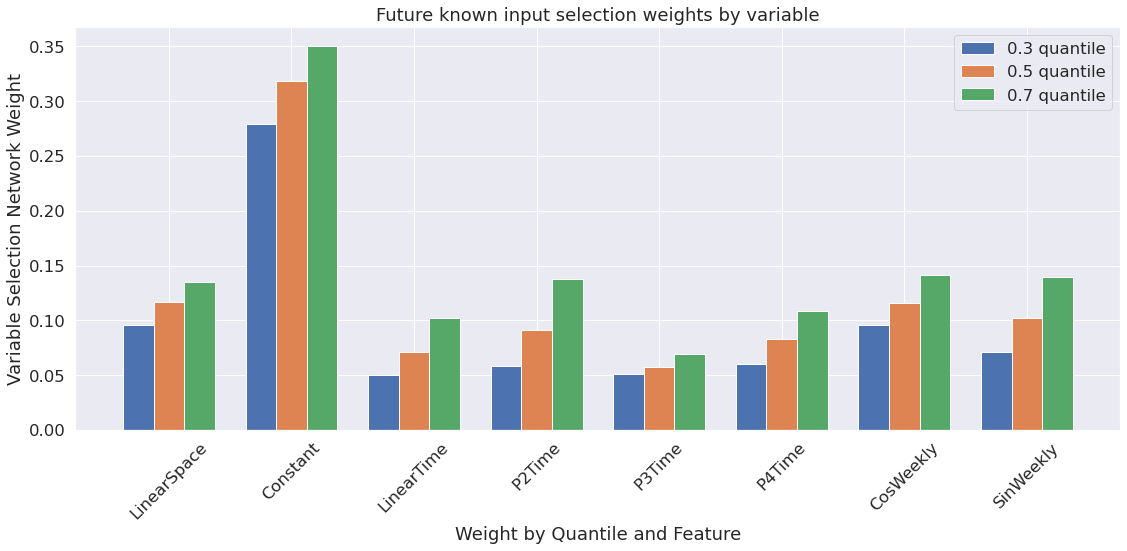

Saving output/figures/Observed input selection weights by variable.png


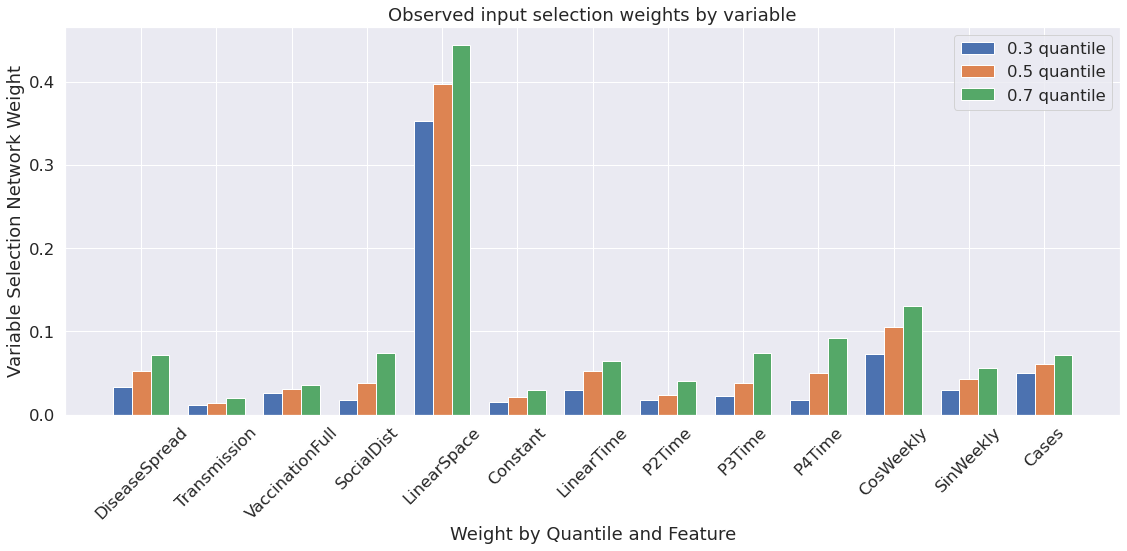

In [28]:
plotter = PlotWeights(parameterManager.col_mappings, train_attn_weights, figure_folder, show=True)
"""## Static variables"""

plotter.plot_static_weights()

"""## Future known input"""

plotter.plot_future_weights()

"""## Observed weights"""

plotter.plotObservedWeights()